Timetracking: 1:30h

In [1]:
import pandas as pd
import joblib
import shap
from shap.maskers import Independent
import matplotlib.pyplot as plt
from comparers import plot_decision_boundary, _encode_one_hot, _calc_log_odds_from_log_proba
from explainers import SameTypeExplanationsNamespace, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       merge_explanations
import numpy as np
import pandas as pd
import pickle
import cloudpickle
from matplotlib.colors import Normalize
import scipy as sp
from util import get_rules
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.cm as cm
shap.initjs()
%matplotlib inline
task_name = '01'

In [2]:
with open(task_name + '.expl', 'rb') as f:
    label_explainer, proba_explainer, log_odds_explainer, explanations = pickle.load(f)
clf_a = joblib.load('model_A.joblib')
y_pred = clf_a.predict(explanations.data)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


# Explain the decision boundary of a machine learning model

## Local Explanations

Here, I will use a form of supervised clustering - by using the leafs of a decision tree, trained on the original instances data to predict their SHAP values. I tried different settings for the number of clusters, but 15 resulted in good cluster sizes, decision plots per cluster without too much differing structure and easy to read decision rules.

In [3]:
from sklearn.tree import export_text

In [10]:
n_clusters = 15
cluster_names = np.array([f'c{i+1}' for i in range(n_clusters)])
shap_values = explanations.log_odds
values = shap_values.values.reshape(
        (shap_values.values.shape[0],
         shap_values.values.shape[1] * shap_values.values.shape[2]))
tree = DecisionTreeRegressor(max_leaf_nodes=n_clusters)
tree.fit(shap_values.data, values)

DecisionTreeRegressor(max_leaf_nodes=15)

In [11]:
leaf_node_ids = np.where(tree.tree_.children_left == -1)[0]
def predict_clusters(X):
    node_ids = tree.apply(X)
    return np.searchsorted(leaf_node_ids, node_ids)
clustering  = predict_clusters(explanations.data)
with open(task_name + '.tree', 'wb') as f:
    cloudpickle.dump((clustering, predict_clusters), f, pickle.HIGHEST_PROTOCOL)

In [12]:
occurences = np.zeros((leaf_node_ids.shape[0], len(explanations.output_names)), dtype=int)
for class_idx in range(len(explanations.output_names)):
    indices, counts = np.unique(clustering[y_pred == class_idx], return_counts=True)
    occurences[indices, class_idx] = counts
occurences = pd.DataFrame(occurences, index=leaf_node_ids, columns=explanations.output_names)

In [13]:
rules = get_rules(tree, explanations.feature_names)
print('\n'.join([f'{cluster_name}: {rule}' for cluster_name, rule in zip(cluster_names, rules)]))

c1: (LSTAT > 10.165) & (LSTAT > 15.554) & (RAD > 11.494) [33 samples]
c2: (LSTAT <= 10.165) & (LSTAT <= 5.474) & (ZN <= 24.238) & (CRIM <= 1.282) [33 samples]
c3: (LSTAT > 10.165) & (LSTAT > 15.554) & (RAD <= 11.494) & (LSTAT > 19.649) [21 samples]
c4: (LSTAT > 10.165) & (LSTAT <= 15.554) & (INDUS <= 16.57) [20 samples]
c5: (LSTAT > 10.165) & (LSTAT > 15.554) & (RAD <= 11.494) & (LSTAT <= 19.649) & (DIS <= 3.083) [17 samples]
c6: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS <= 16.01) & (LSTAT > 7.878) [15 samples]
c7: (LSTAT <= 10.165) & (LSTAT <= 5.474) & (ZN > 24.238) & (CRIM > 0.027) [15 samples]
c8: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS > 16.01) [14 samples]
c9: (LSTAT > 10.165) & (LSTAT > 15.554) & (RAD <= 11.494) & (LSTAT <= 19.649) & (DIS > 3.083) [13 samples]
c10: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS <= 16.01) & (LSTAT <= 7.878) & (DIS > 3.791) [13 samples]
c11: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS <= 16.01) & (LSTAT <= 7.878) & (DIS <= 3.791) [12 samples

Next, we see the plot of every feature vs. every other feature, colored by clusters.

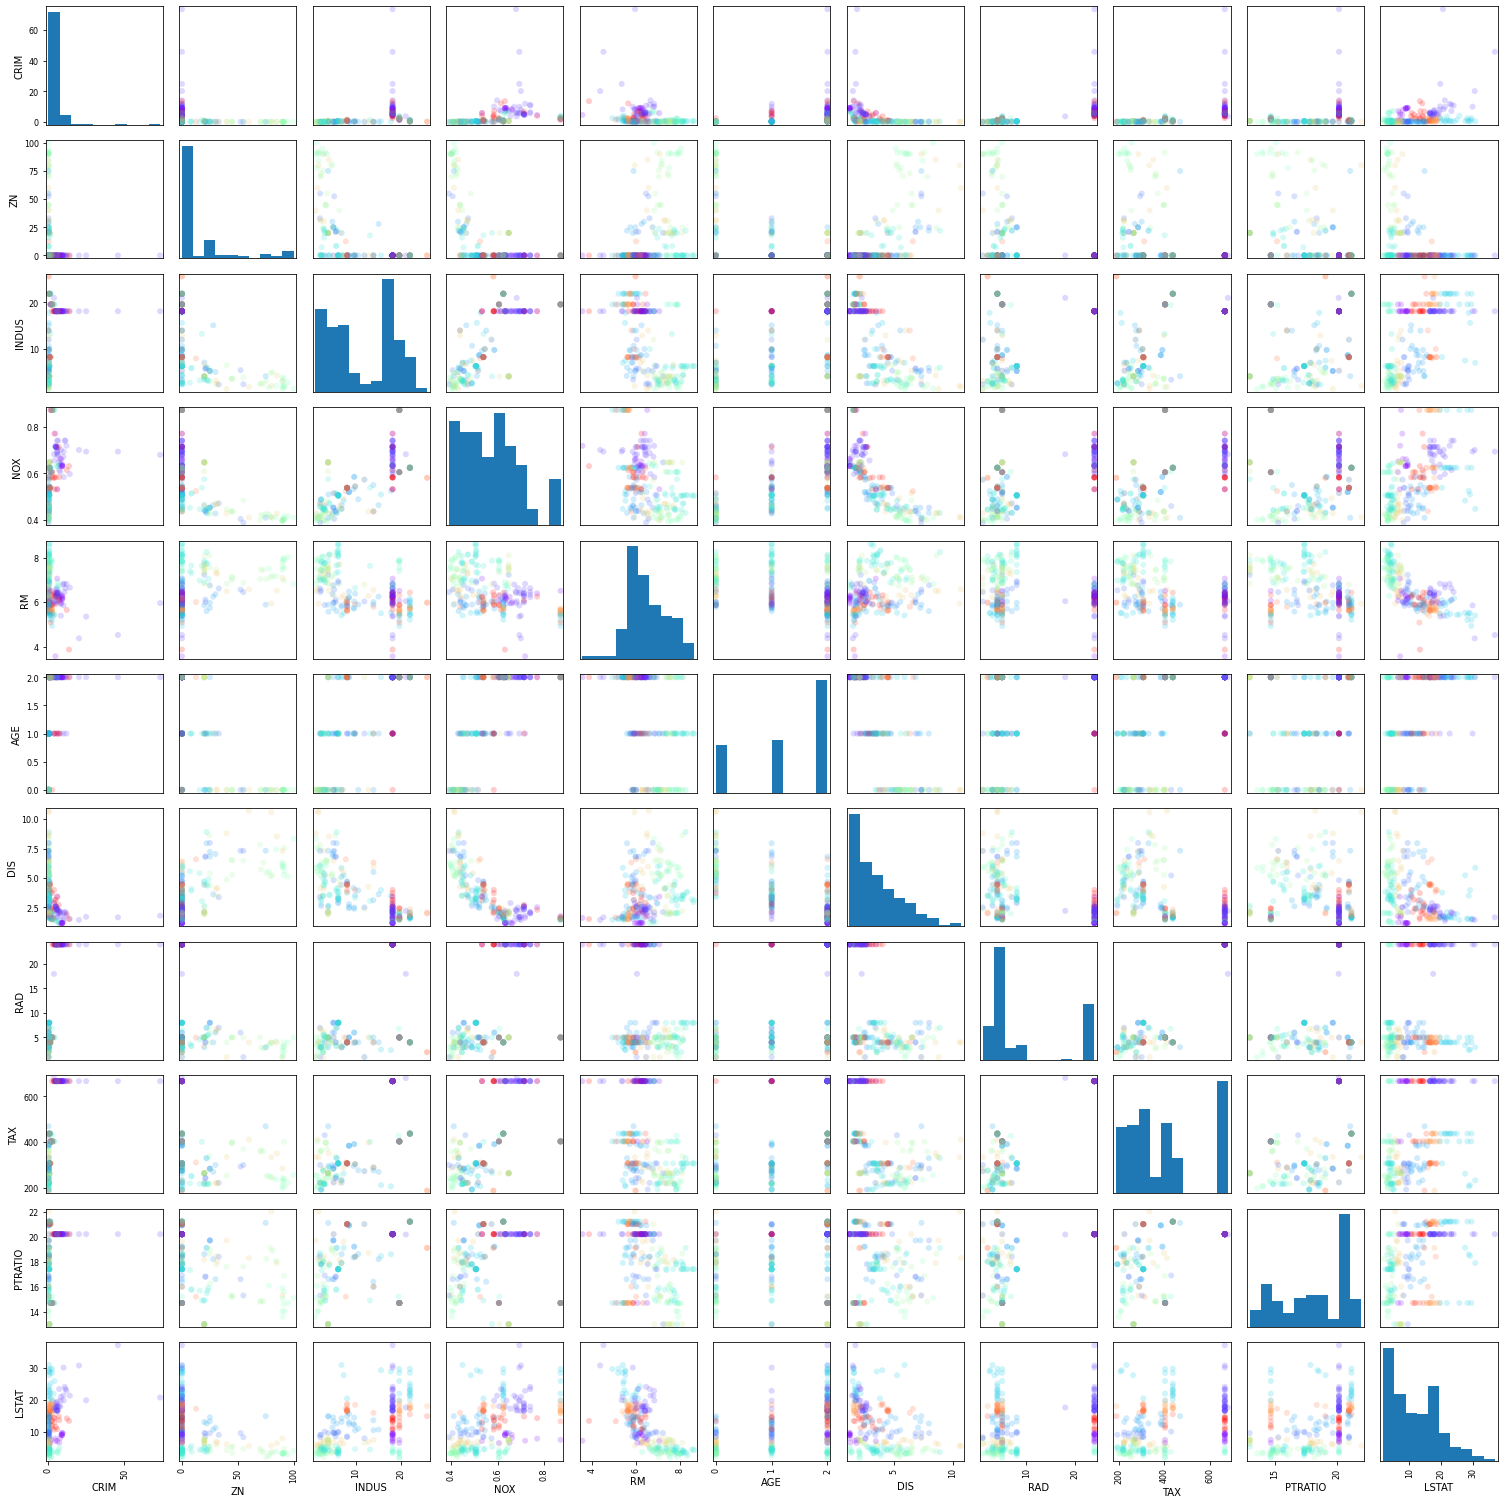

In [14]:
cmap = plt.get_cmap('rainbow')
df = pd.DataFrame(explanations.data, columns=explanations.feature_names)
colors = cmap(Normalize(0, n_clusters-1)(clustering))
axes = pd.plotting.scatter_matrix(df, figsize=(21, 21), marker='o', alpha=0.2, c=colors)
plt.tight_layout()

Next, we see for every cluster the mean SHAP values per feature per class. This corresponds to the mean influence each feature has on the class. And we see the decision plots for every class. This allows us to evaluate, if the decision paths of the instances within the cluster are very similar or not.

c1: (LSTAT > 10.165) & (LSTAT > 15.554) & (RAD > 11.494) [33 samples]
(array([1, 2], dtype=int32), array([ 2, 12]))


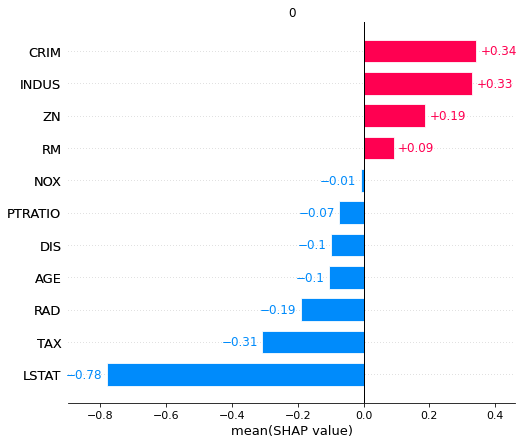

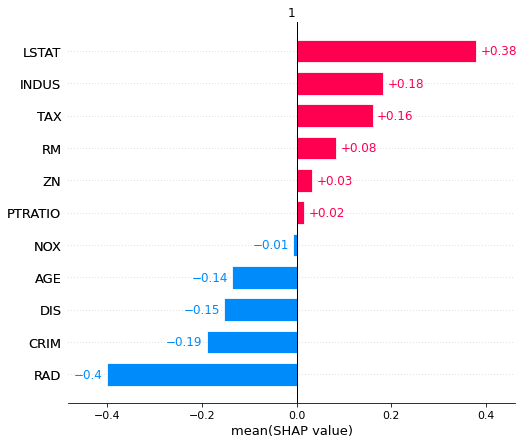

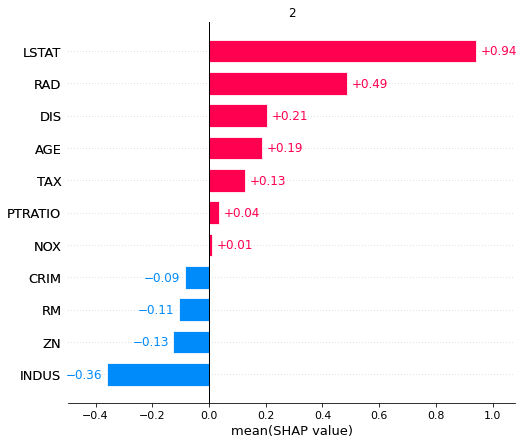

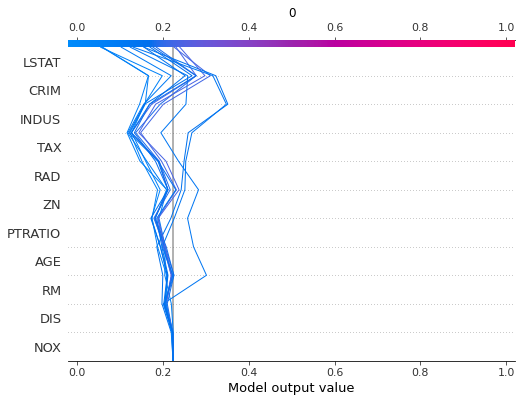

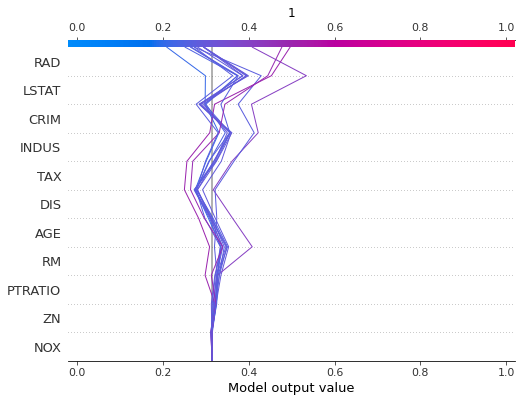

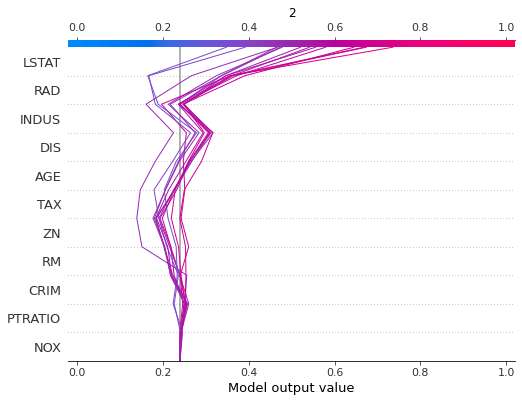

c2: (LSTAT <= 10.165) & (LSTAT <= 5.474) & (ZN <= 24.238) & (CRIM <= 1.282) [33 samples]
(array([0], dtype=int32), array([33]))


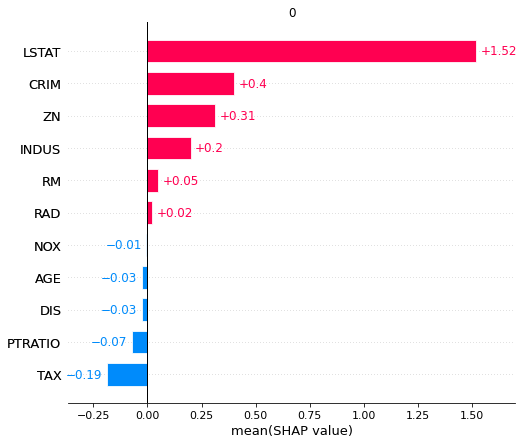

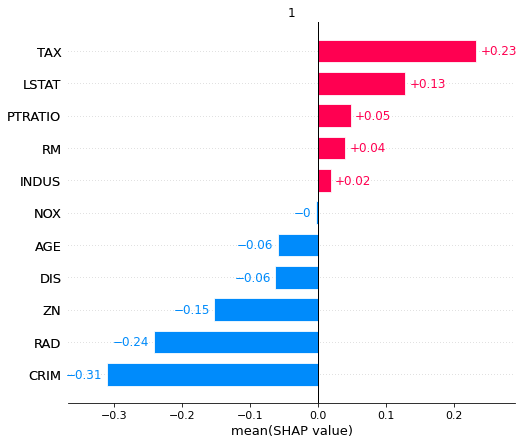

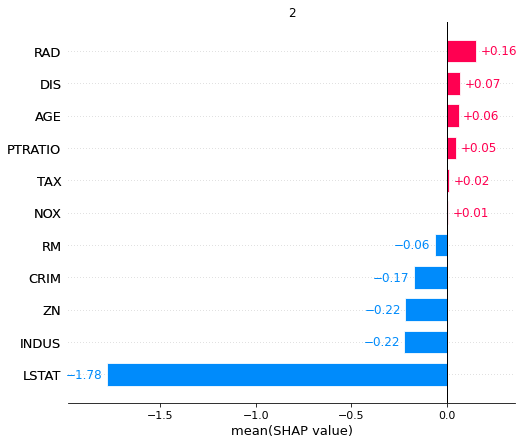

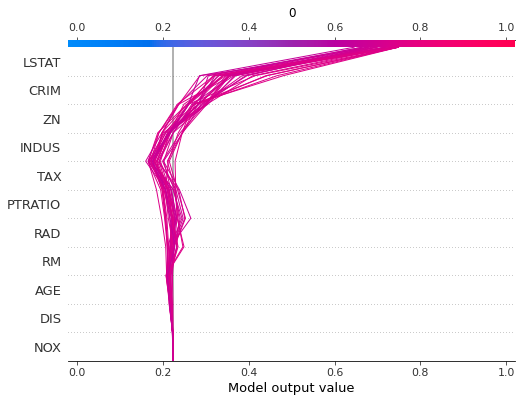

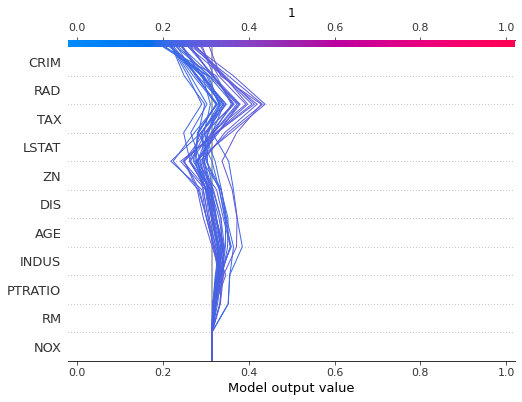

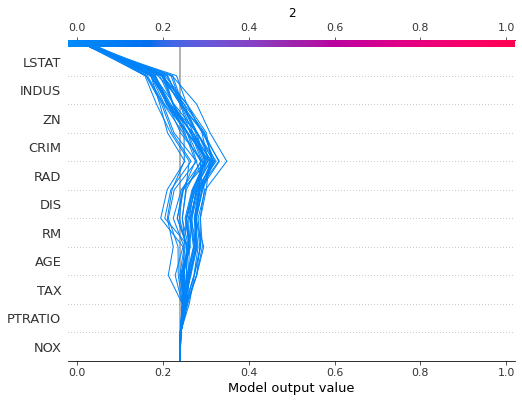

c3: (LSTAT > 10.165) & (LSTAT > 15.554) & (RAD <= 11.494) & (LSTAT > 19.649) [21 samples]
(array([1, 2], dtype=int32), array([14,  1]))


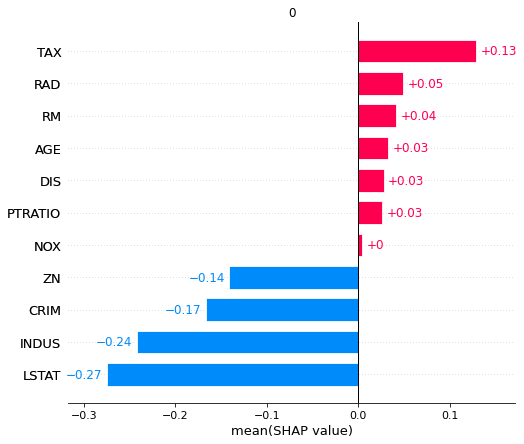

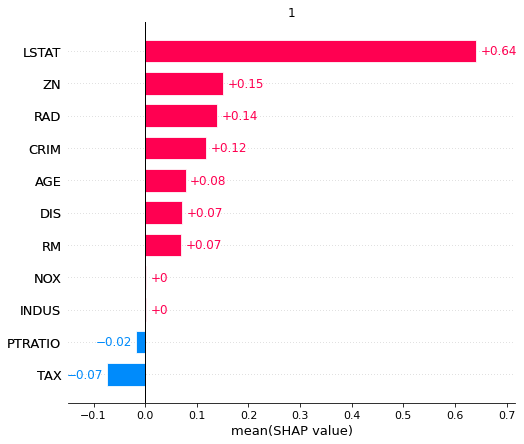

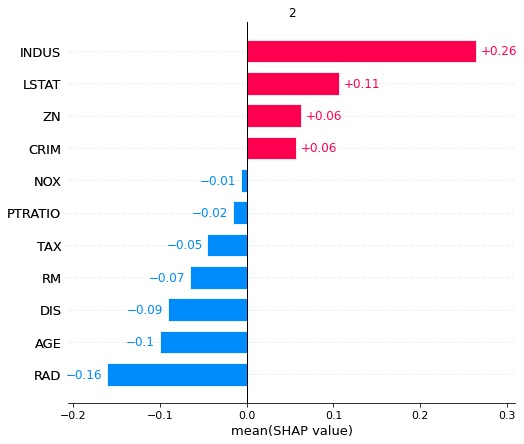

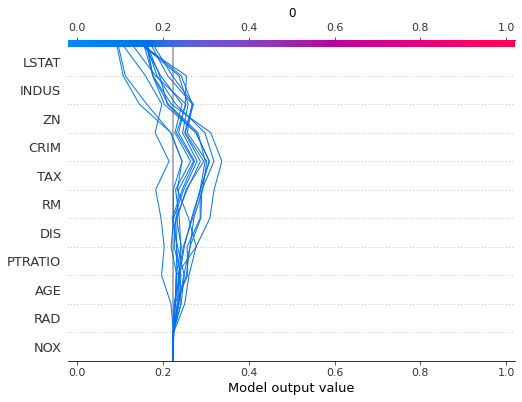

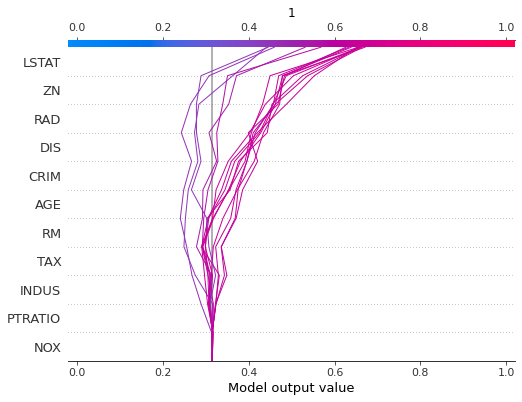

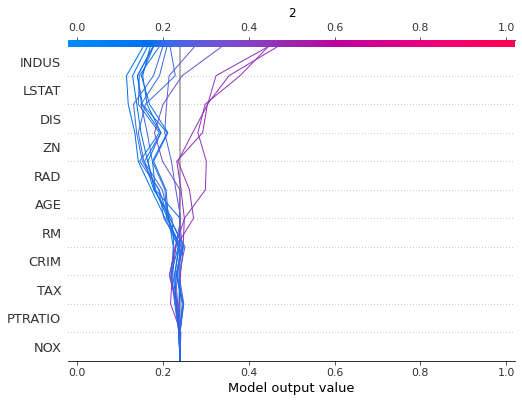

c4: (LSTAT > 10.165) & (LSTAT <= 15.554) & (INDUS <= 16.57) [20 samples]
(array([0, 1], dtype=int32), array([ 1, 19]))


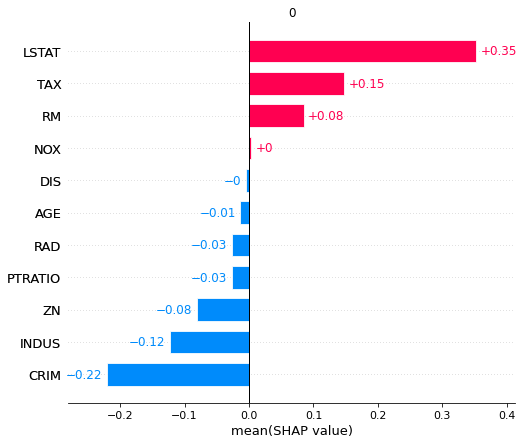

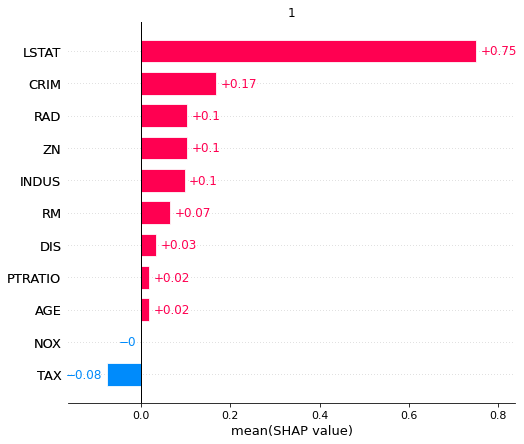

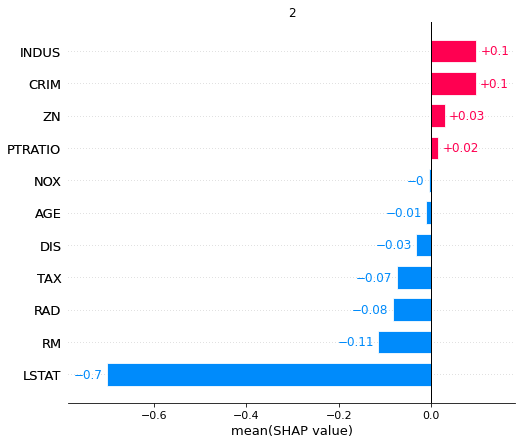

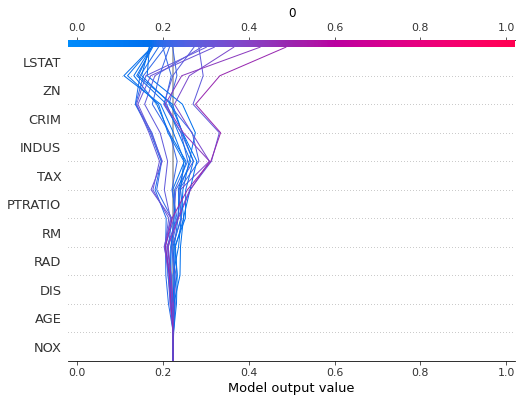

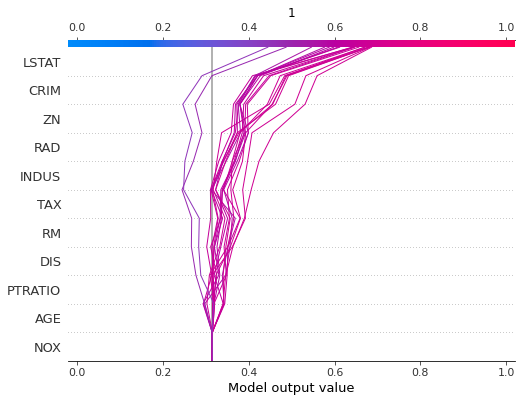

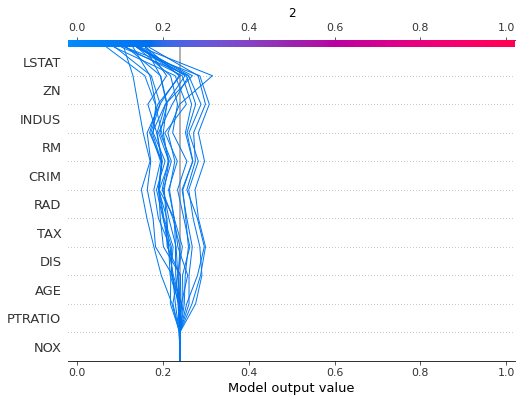

c5: (LSTAT > 10.165) & (LSTAT > 15.554) & (RAD <= 11.494) & (LSTAT <= 19.649) & (DIS <= 3.083) [17 samples]
(array([0], dtype=int32), array([21]))


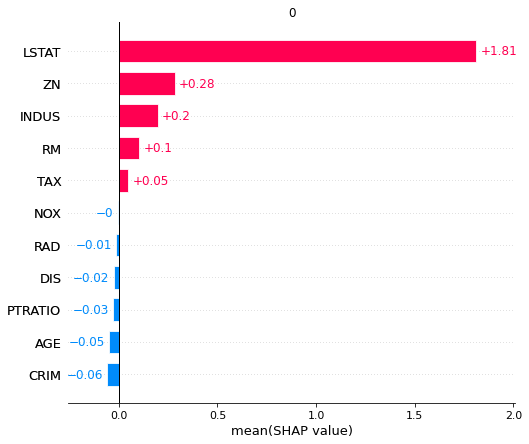

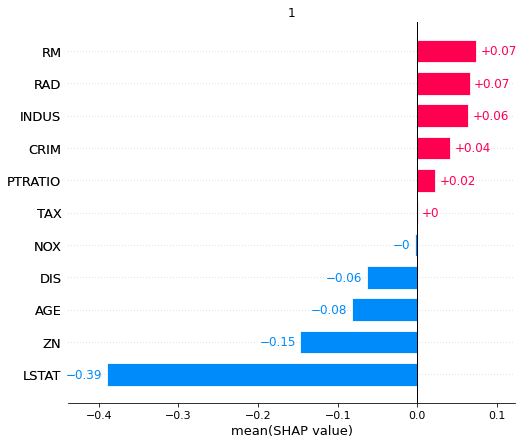

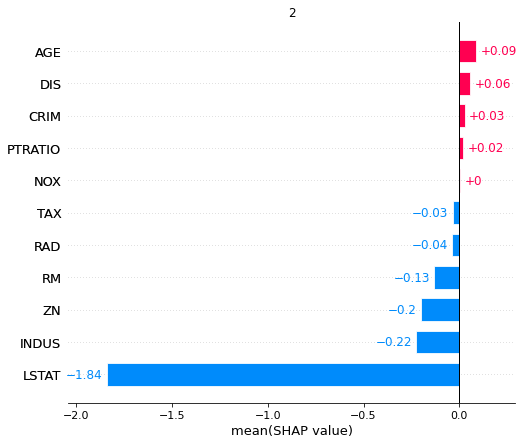

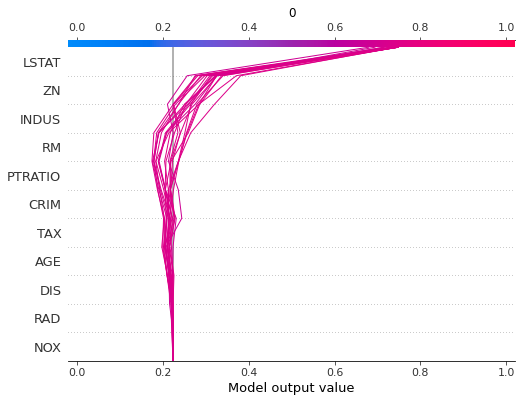

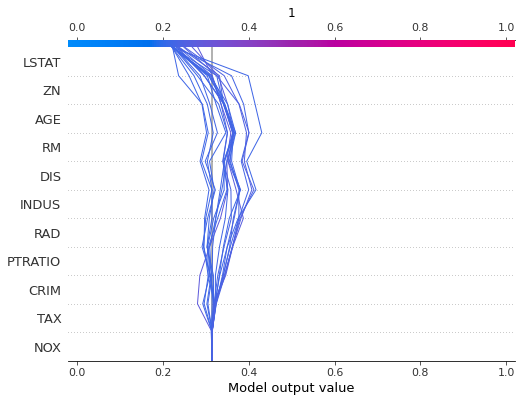

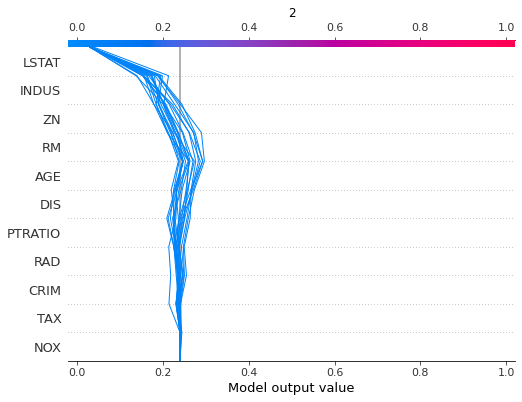

c6: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS <= 16.01) & (LSTAT > 7.878) [15 samples]
(array([2], dtype=int32), array([33]))


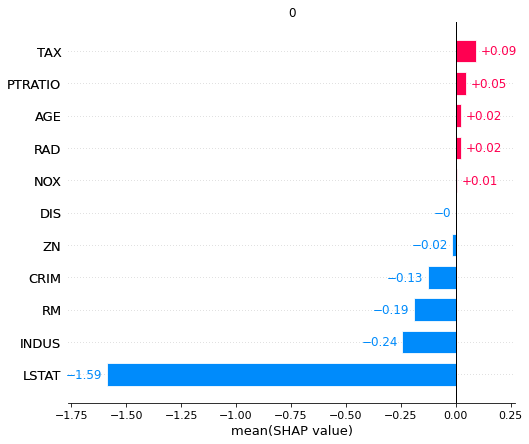

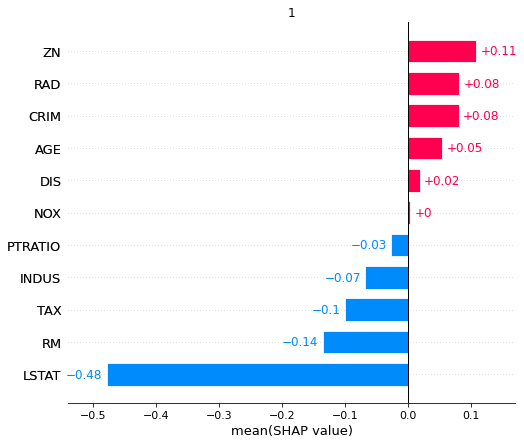

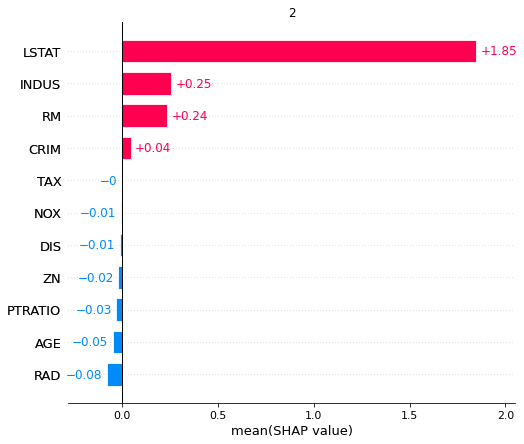

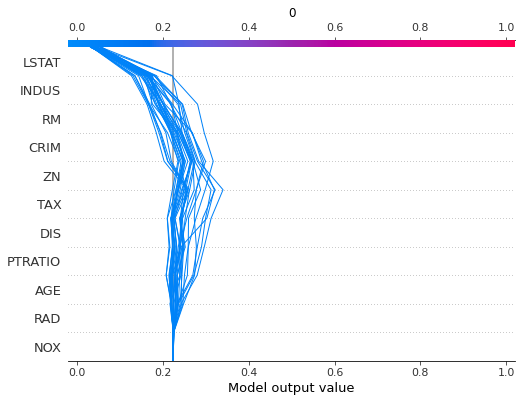

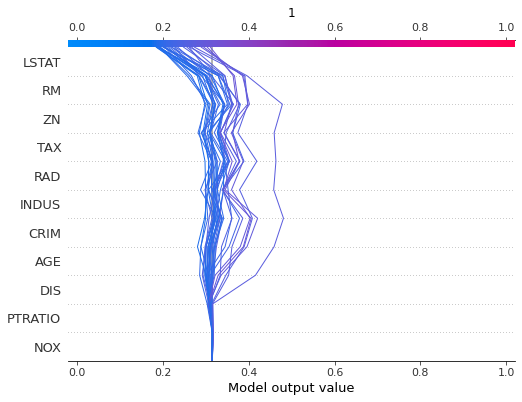

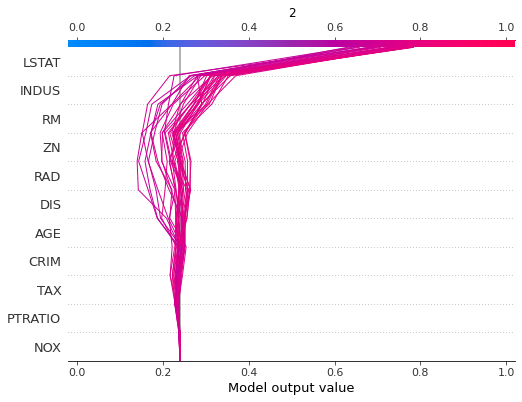

c7: (LSTAT <= 10.165) & (LSTAT <= 5.474) & (ZN > 24.238) & (CRIM > 0.027) [15 samples]
(array([2], dtype=int32), array([11]))


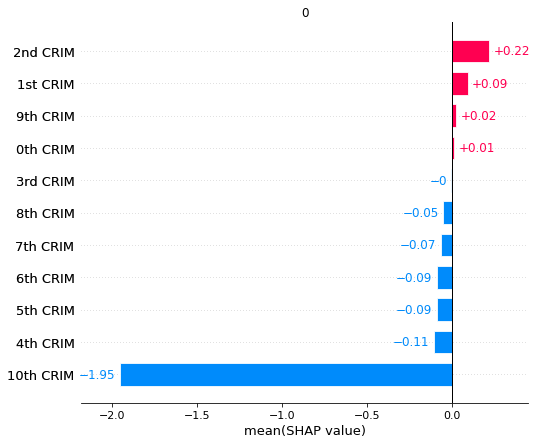

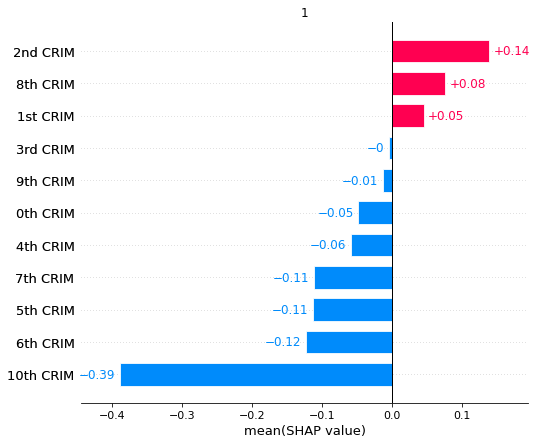

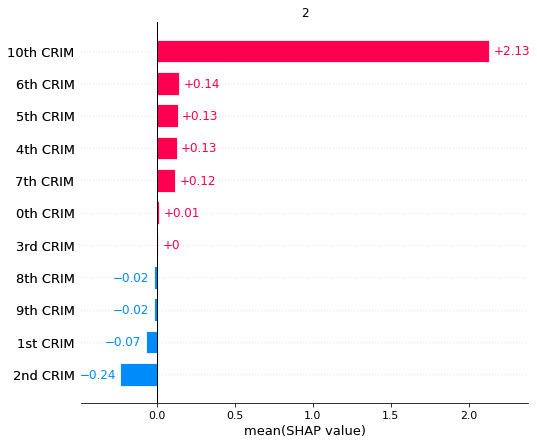

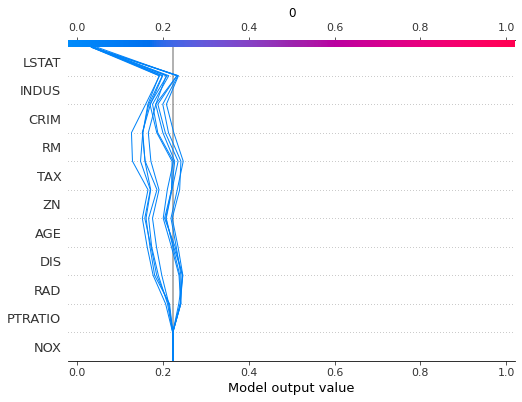

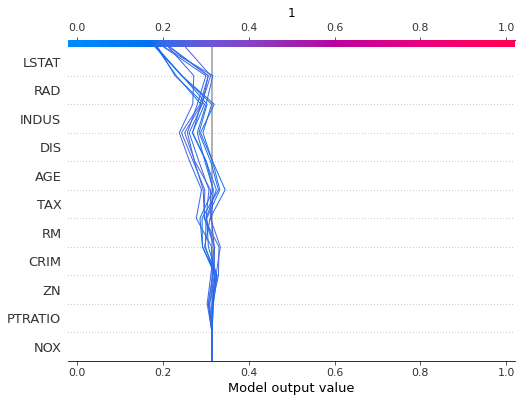

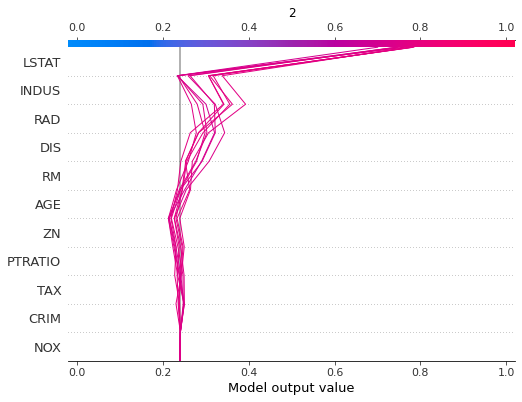

c8: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS > 16.01) [14 samples]
(array([2], dtype=int32), array([11]))


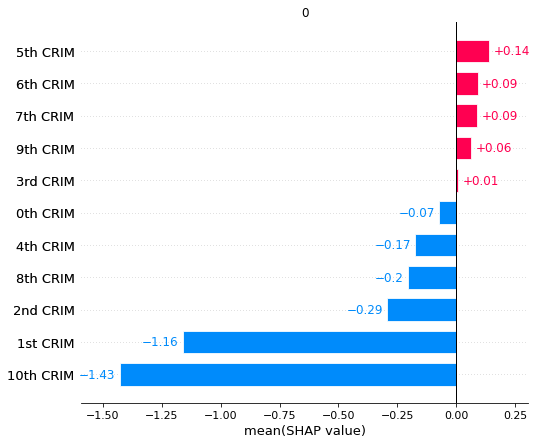

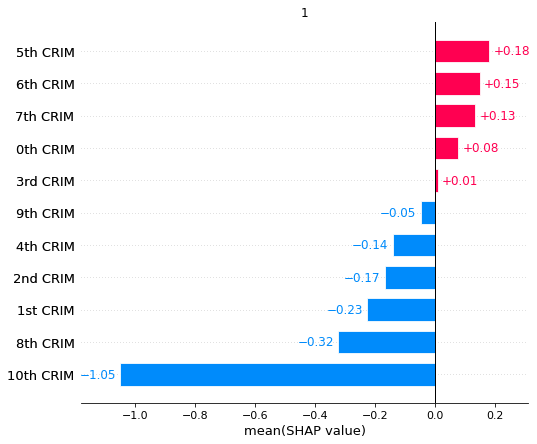

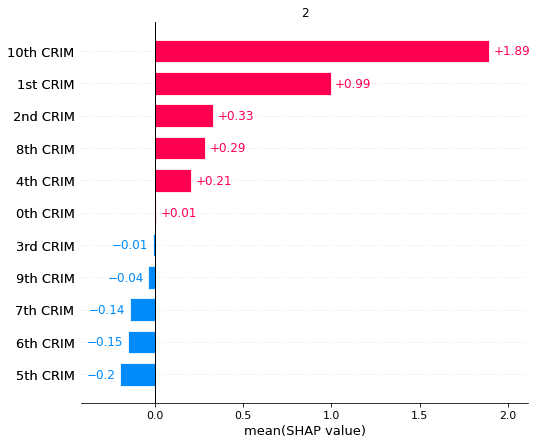

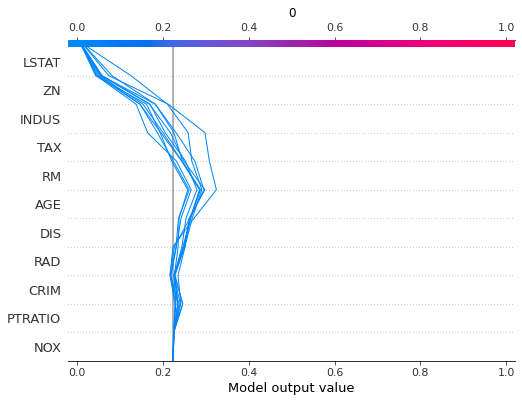

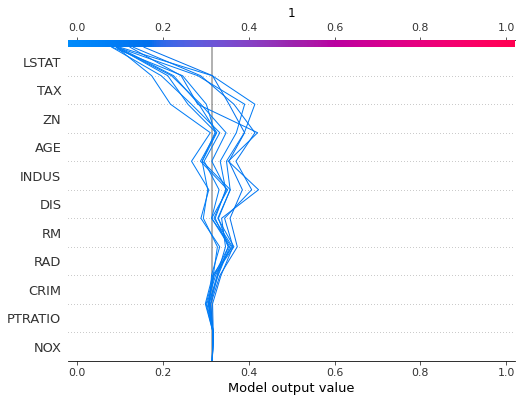

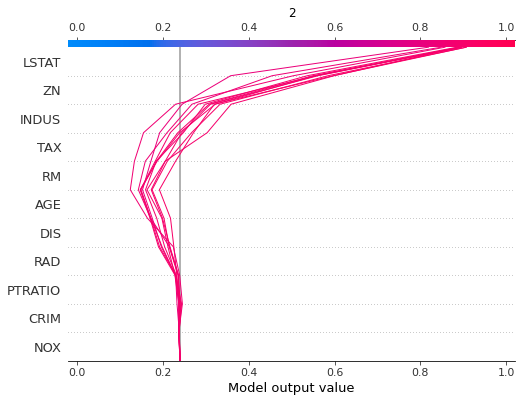

c9: (LSTAT > 10.165) & (LSTAT > 15.554) & (RAD <= 11.494) & (LSTAT <= 19.649) & (DIS > 3.083) [13 samples]
(array([2], dtype=int32), array([15]))


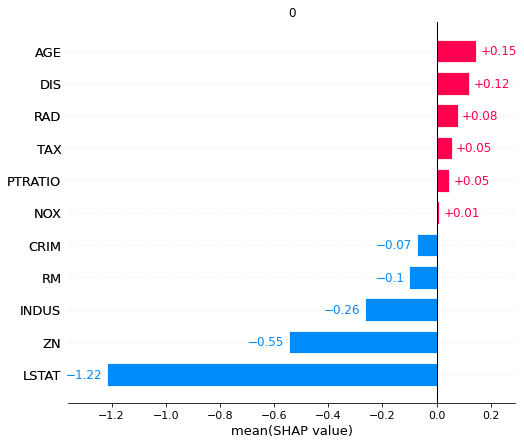

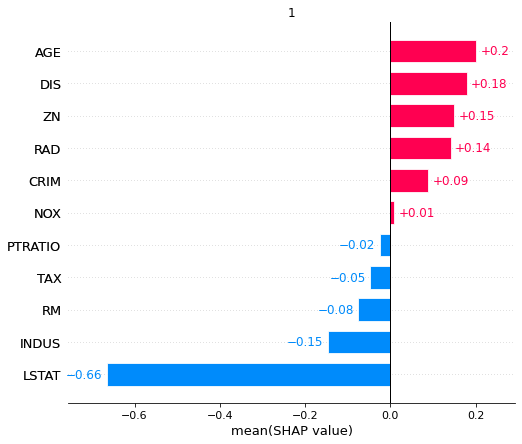

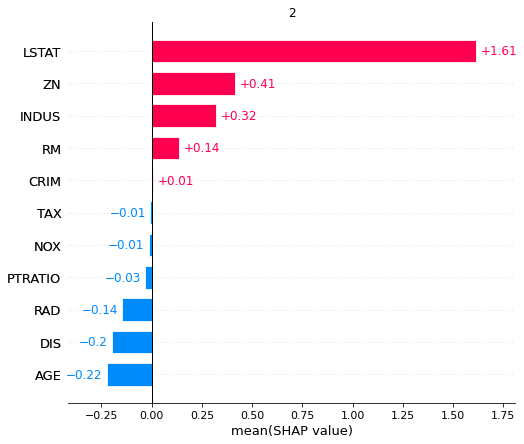

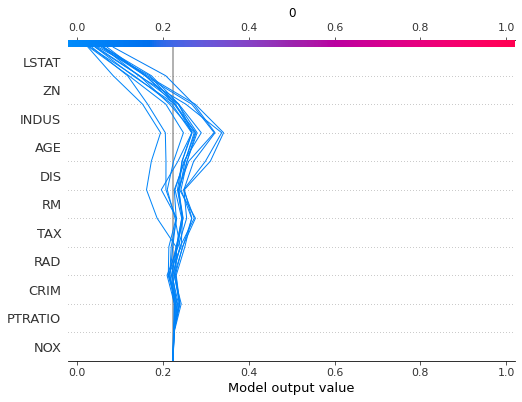

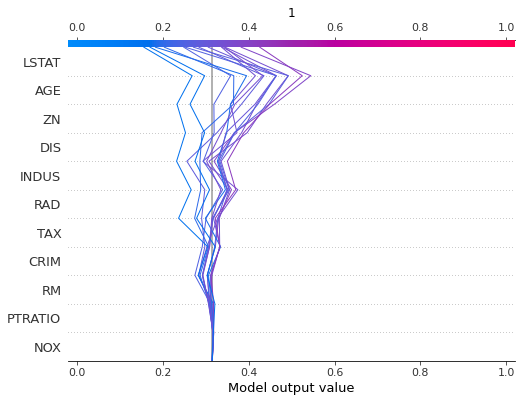

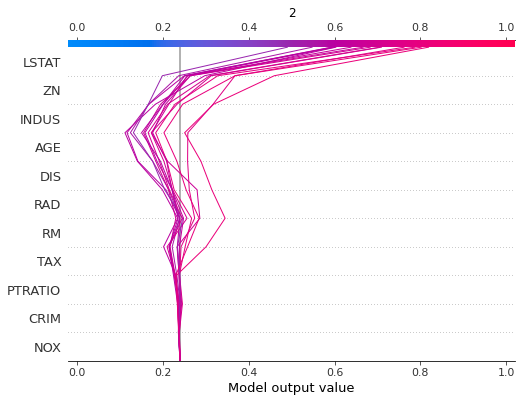

c10: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS <= 16.01) & (LSTAT <= 7.878) & (DIS > 3.791) [13 samples]
(array([2], dtype=int32), array([12]))


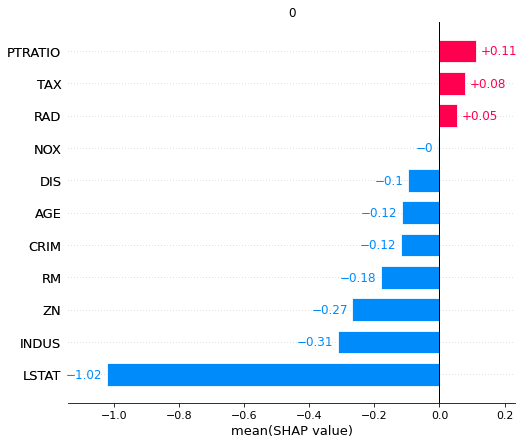

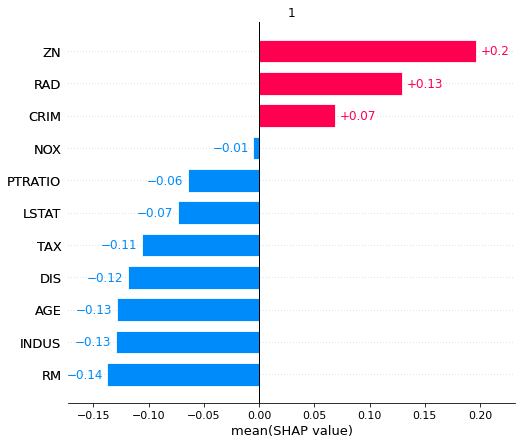

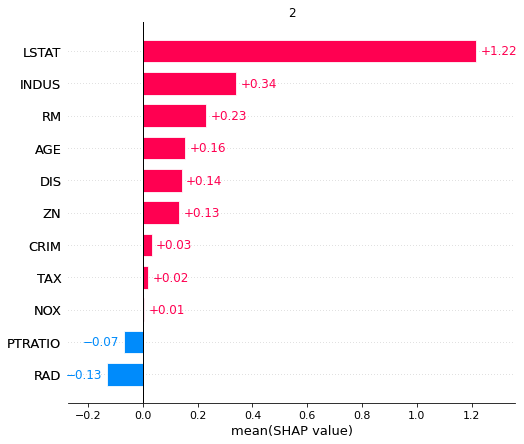

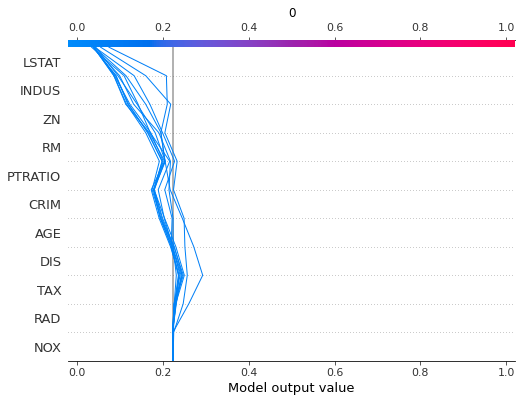

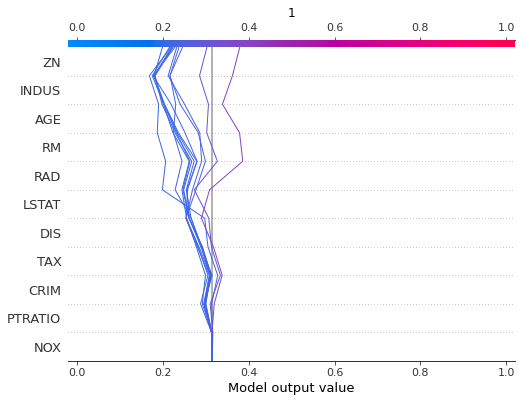

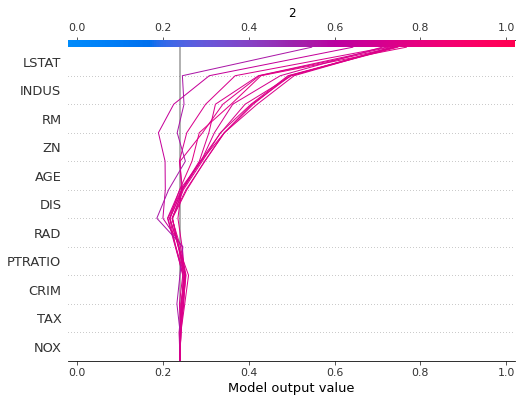

c11: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS <= 16.01) & (LSTAT <= 7.878) & (DIS <= 3.791) [12 samples]
(array([1, 2], dtype=int32), array([10,  3]))


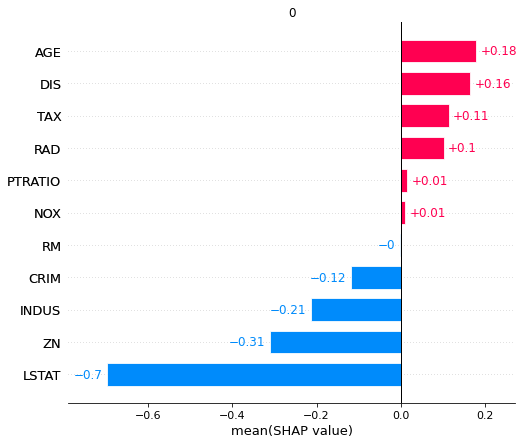

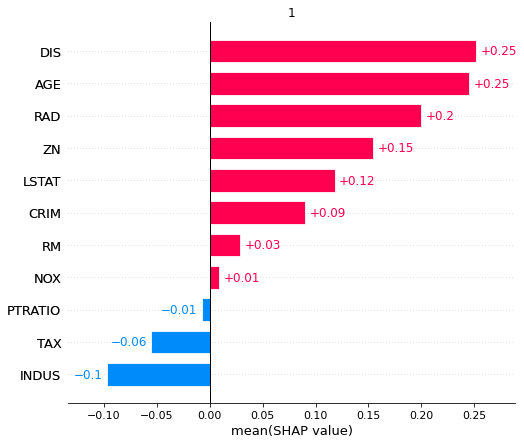

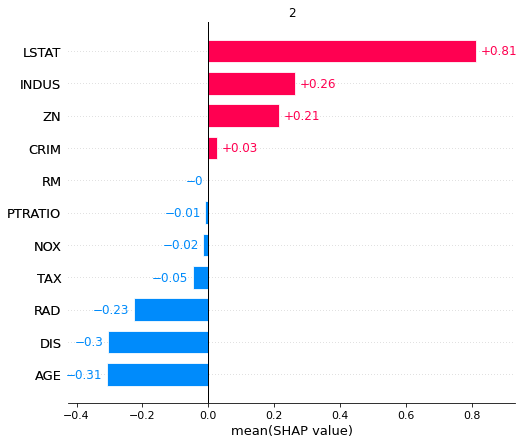

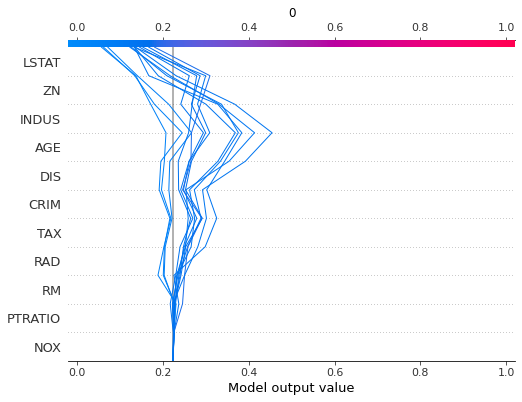

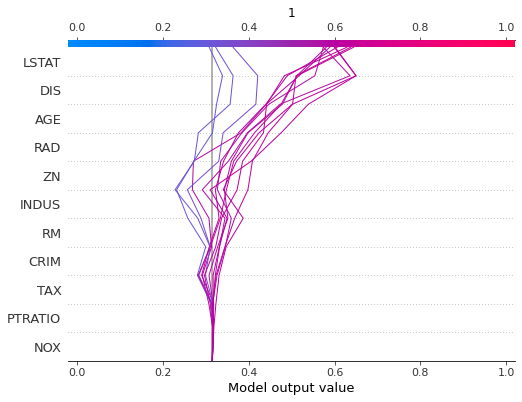

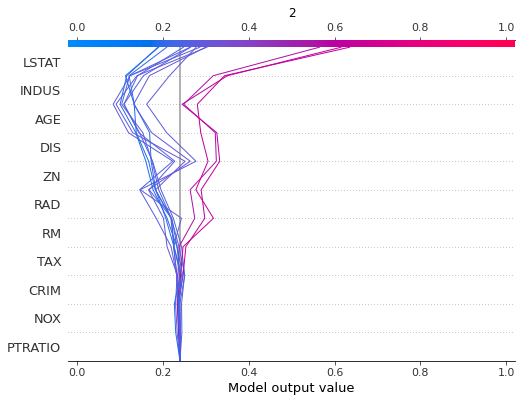

c12: (LSTAT > 10.165) & (LSTAT <= 15.554) & (INDUS > 16.57) & (RAD > 14.5) [11 samples]
(array([0], dtype=int32), array([17]))


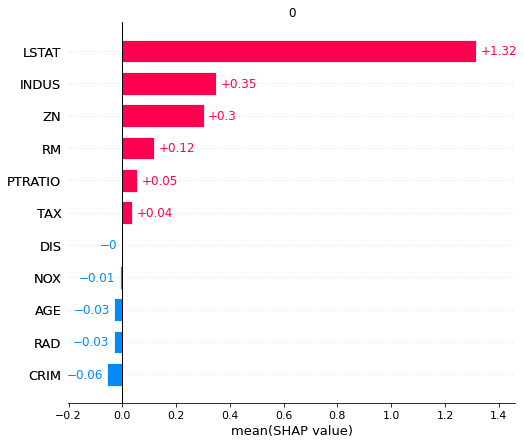

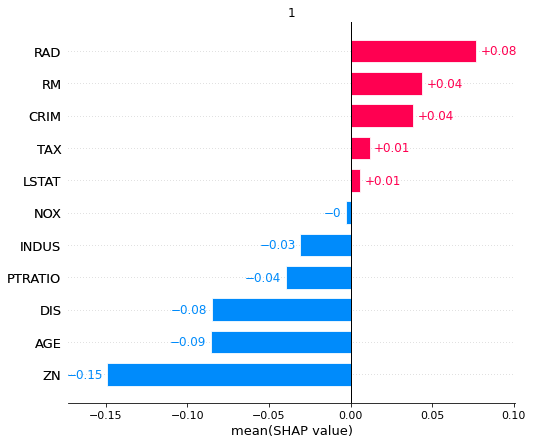

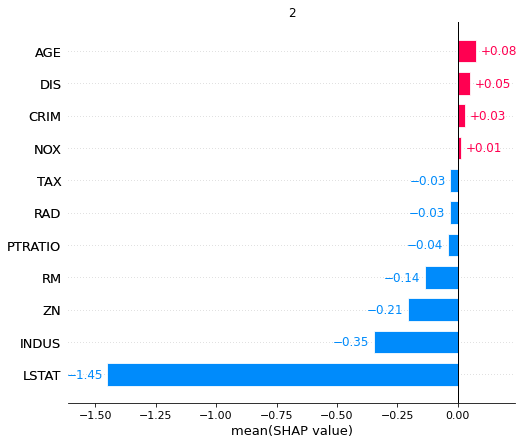

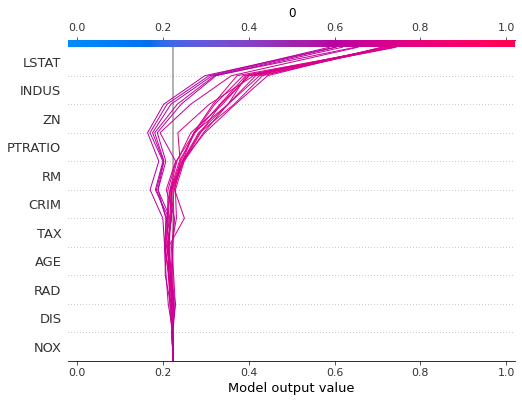

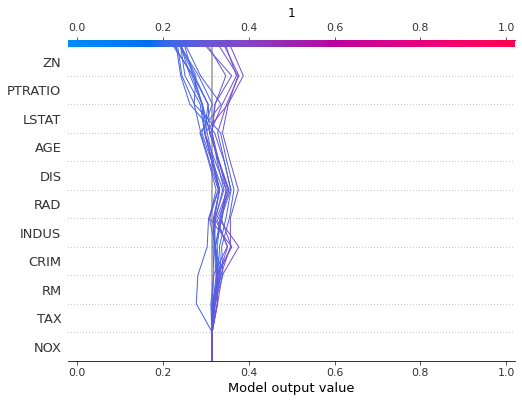

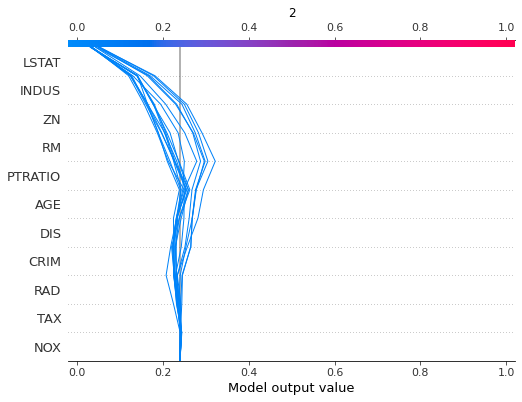

c13: (LSTAT <= 10.165) & (LSTAT <= 5.474) & (ZN > 24.238) & (CRIM <= 0.027) [11 samples]
(array([0, 1], dtype=int32), array([6, 7]))


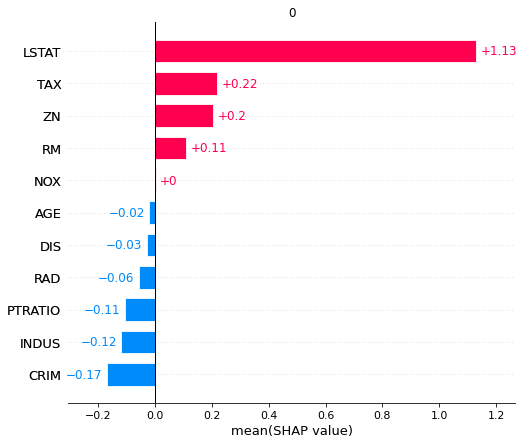

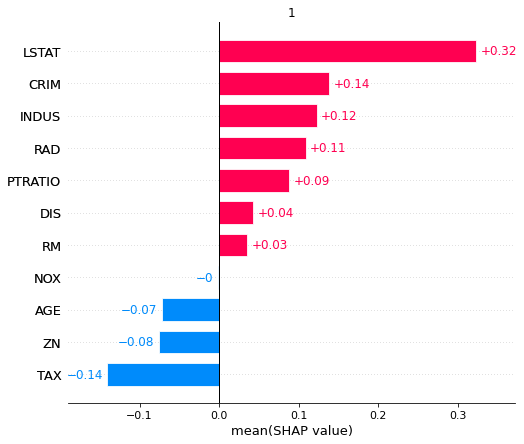

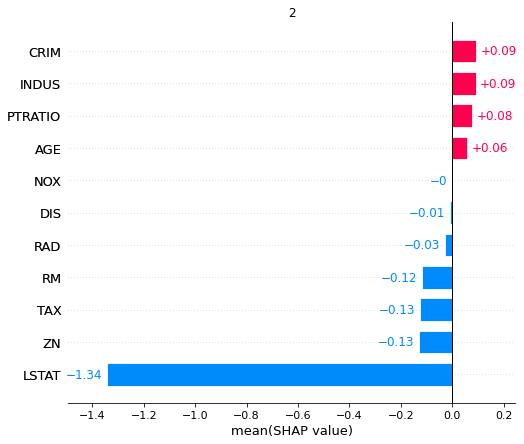

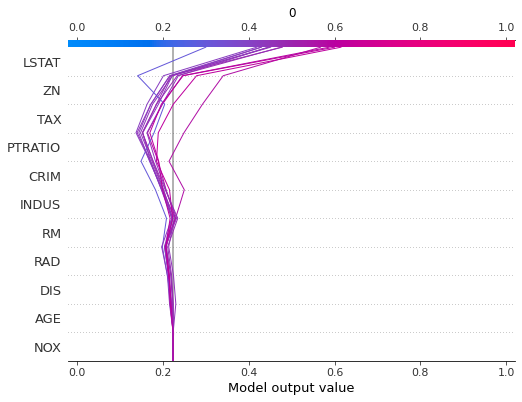

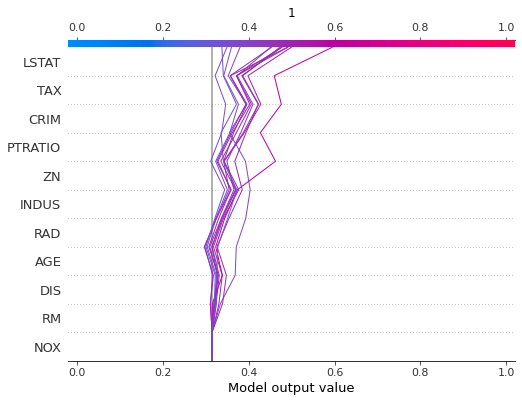

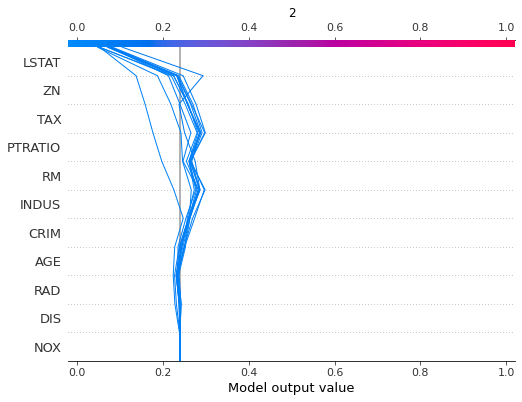

c14: (LSTAT <= 10.165) & (LSTAT <= 5.474) & (ZN <= 24.238) & (CRIM > 1.282) [11 samples]
(array([0, 1], dtype=int32), array([6, 1]))


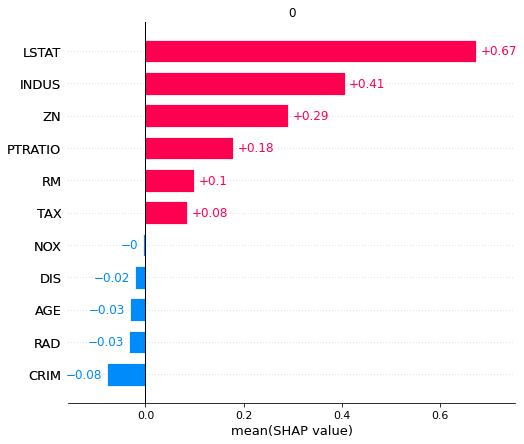

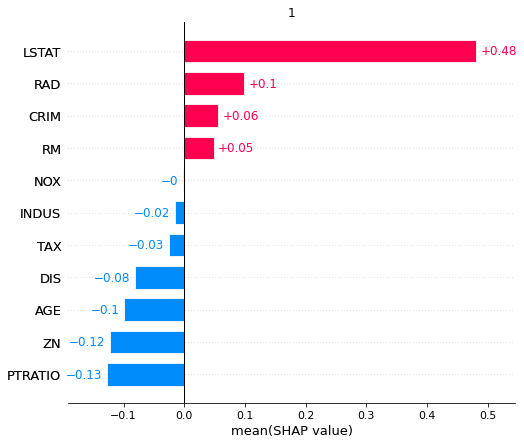

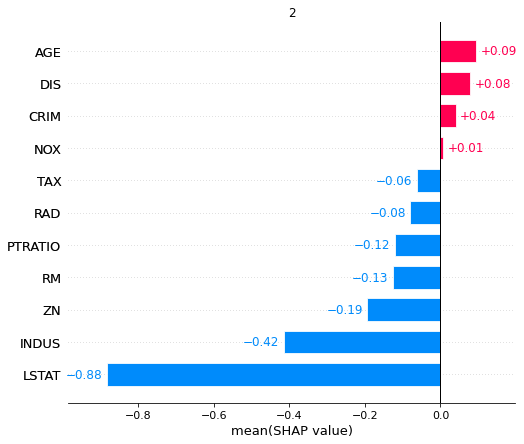

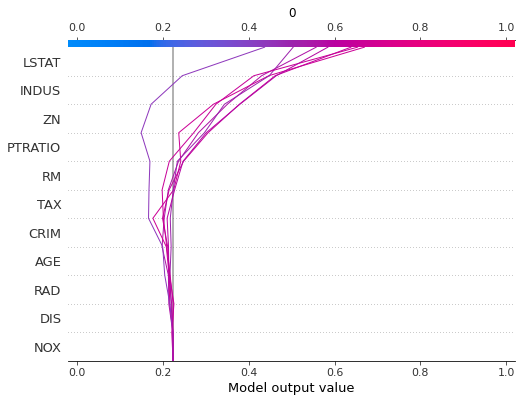

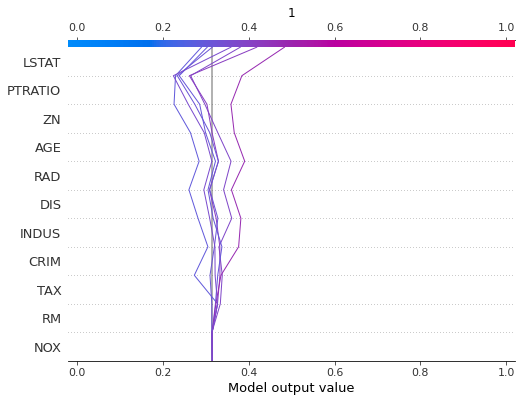

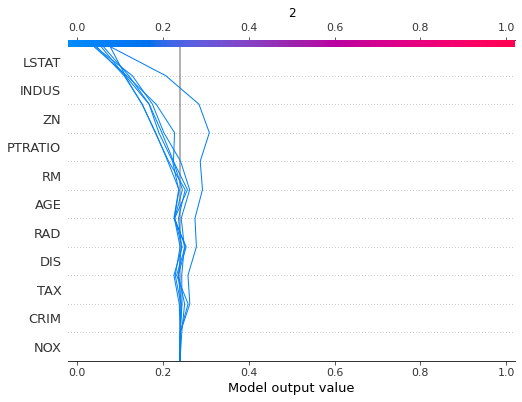

c15: (LSTAT > 10.165) & (LSTAT <= 15.554) & (INDUS > 16.57) & (RAD <= 14.5) [7 samples]
(array([0, 1], dtype=int32), array([5, 6]))


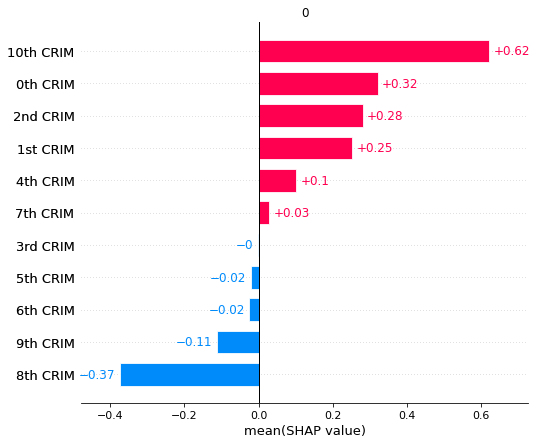

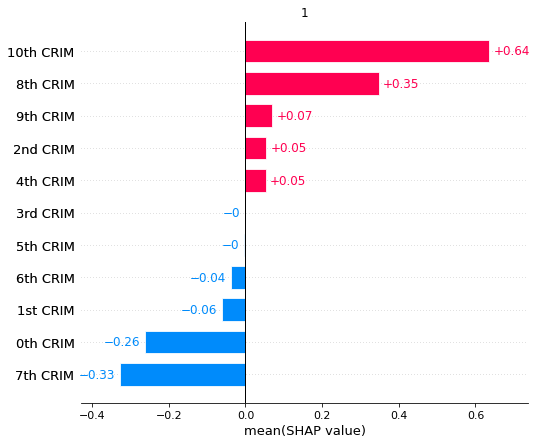

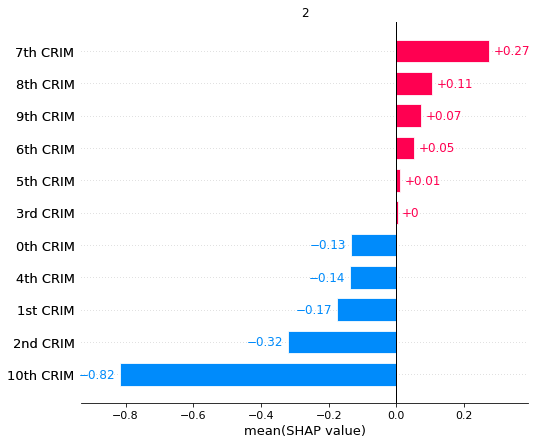

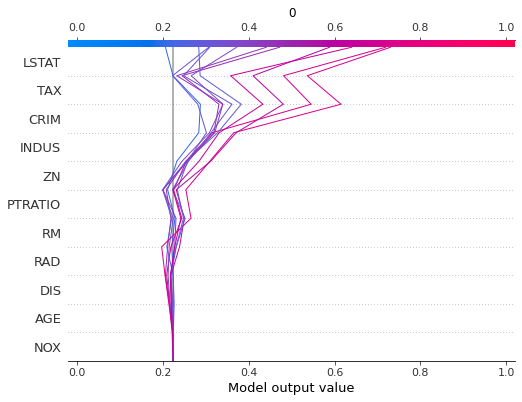

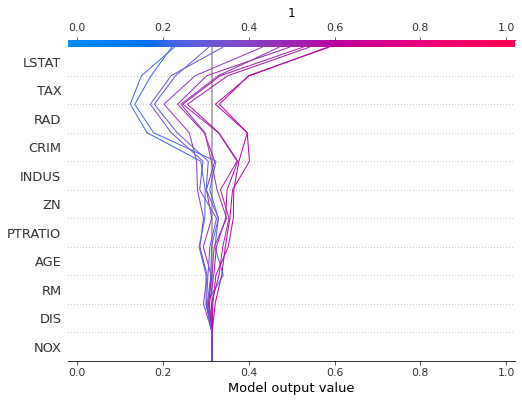

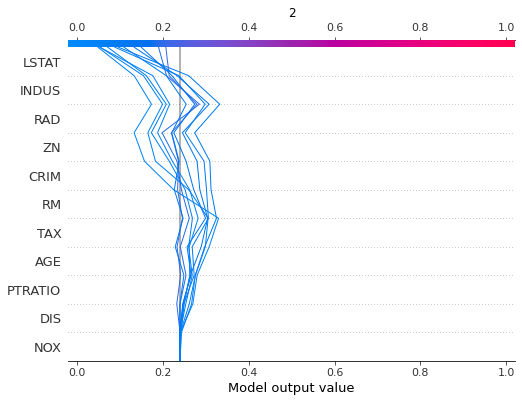

In [15]:
for cluster in range(n_clusters):
    cluster_name = cluster_names[cluster]
    print(cluster_name + ': ' + rules[cluster])
    mask = clustering == cluster
    y_pred_ = y_pred[mask]
    print(np.unique(y_pred_, return_counts=True))
    explanations_ = explanations[mask]
    shap_values  = explanations_.log_odds
    for class_idx in range(explanations_.shape[2]):
        plot_feature_importance_bar(shap_values[:, :, class_idx].mean(0), title=explanations.output_names[class_idx])
    for class_idx in range(explanations_.shape[2]):
        shap_values_ = shap_values[:, :, class_idx]
        shap.decision_plot(shap_values_.base_values[0], shap_values_.values, features=shap_values_.data,
                           feature_names=shap_values_.feature_names, link='logit', title=explanations.output_names[class_idx])